In [1]:
import sys
import os
sys.path.append(os.path.abspath('../'))

from evaluation import *
from data_loader import *
import random
from datetime import datetime
import numpy as np

In [2]:
colors = {
    "DQN": 'darkorange',
    "PPO": 'forestgreen',
    "CMA": 'cyan',
    "ODT": 'blueviolet'
}

In [3]:
experiments = range(4000, 4036)
target_agg_count = 6

exp_power_data = []

for ind, exp_num in enumerate(experiments):
    config_fname = f'./Exp_{exp_num}/config.yaml'
    
    c = load_config_file(config_fname)
    nn_c = c['nn_hyperparameters']
    federated_c = c['federated_learning_settings']
    algo_c = c['algorithm_settings']
    env_c = c['environment_settings']
    eval_c = c['eval_config']

    if federated_c['aggregation_count'] != target_agg_count:
        print(f"Experiment {exp_num} does not have matching aggregation level")
        continue
    
    ev_info = []

    seed = env_c['seed']

    algorithm_dm = algo_c['algorithm']
    
    def load_from_json_with_error_handling(filepath, columns_specific):
        try:
            return read_csv_data(filepath, columns=columns_specific)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON from {filepath}: {e.msg} at line {e.lineno}, column {e.colno}")
            return None  # Handle the error and return None or an empty object
    
    
    d_base = f"../../../../storage_1/metrics/Exp_{exp_num}"
    
    if not os.path.exists(d_base):
        d_base = f"../metrics/Exp_{exp_num}"
            
    base_path = f"{d_base}/train/"

    print(f'Loading {base_path}power_and_co2_metrics.csv')
    power_data = load_from_json_with_error_handling(f'{base_path}power_and_co2_metrics.csv', ['time', 'power', 'co2'])
    
    power_data['seed'] = seed
    power_data['exp_num'] = exp_num
    
    power_data['algorithm'] = algorithm_dm
    power_data['season'] = env_c['season']
    power_data['num_aggs'] = federated_c['aggregation_count']
    power_data['eps_per_agg'] = nn_c['num_episodes']

    exp_power_data.append(power_data)

Loading ../../../../storage_1/metrics/Exp_4000/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4001/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4002/train/power_and_co2_metrics.csv
Experiment 4003 does not have matching aggregation level
Experiment 4004 does not have matching aggregation level
Experiment 4005 does not have matching aggregation level
Experiment 4006 does not have matching aggregation level
Experiment 4007 does not have matching aggregation level
Experiment 4008 does not have matching aggregation level
Loading ../../../../storage_1/metrics/Exp_4009/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4010/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4011/train/power_and_co2_metrics.csv
Experiment 4012 does not have matching aggregation level
Experiment 4013 does not have matching aggregation level
Experiment 4014 does not have matching aggregation level
Experiment 40

In [4]:
# Convert data to DataFrame for easier manipulation
df_power = pd.concat(exp_power_data, ignore_index=True)

df_power.head()

,time,power,co2,seed,exp_num,algorithm,season,num_aggs,eps_per_agg
0,2024-11-24 04:36:00,35.375,0.000368,1234,4000,DQN,winter,30,200
1,2024-11-24 04:39:00,35.625,0.000368,1234,4000,DQN,winter,30,200
2,2024-11-24 04:42:00,35.875,0.000368,1234,4000,DQN,winter,30,200
3,2024-11-24 04:45:00,36.000,0.000368,1234,4000,DQN,winter,30,200
4,2024-11-24 04:48:00,36.000,0.000368,1234,4000,DQN,winter,30,200


In [5]:
# Calculate cumulative power for each experiment and add it as a new column
df_power['cumulative_power'] = df_power.groupby('exp_num')['power'].cumsum()

df_power['time'] = pd.to_datetime(df_power['time'], errors='coerce')
df_power['time'] = df_power.groupby('exp_num')['time'].transform(lambda x: (x - x.min()).dt.total_seconds())

df_power['co2'] = df_power['co2'] * 1000 # Convert to grams

# Display the first few rows of the updated DataFrame
df_power.head()

,time,power,co2,seed,exp_num,algorithm,season,num_aggs,eps_per_agg,cumulative_power
0,0.0,35.375,0.367764,1234,4000,DQN,winter,30,200,35.375
1,180.0,35.625,0.367764,1234,4000,DQN,winter,30,200,71.000
2,360.0,35.875,0.367764,1234,4000,DQN,winter,30,200,106.875
3,540.0,36.000,0.367764,1234,4000,DQN,winter,30,200,142.875
4,720.0,36.000,0.367764,1234,4000,DQN,winter,30,200,178.875


In [6]:
# Function to calculate energy in kWh for a single experiment
def calculate_energy_kWh(exp_data):
    # Sort the data by elapsed time
    exp_data_sorted = exp_data.sort_values('time')
    
    # Extract power (W) and time (s)
    power = exp_data_sorted['power'].values  # Power in W
    time_sec = exp_data_sorted['time'].values  # Time in seconds
    
    # Convert time to hours for integration
    time_hours = time_sec / 3600  # Convert seconds to hours
    
    # Handle cases where time_hours may not be strictly increasing
    # Ensure that time_hours is sorted and unique
    if not np.all(np.diff(time_hours) >= 0):
        raise ValueError("Time data must be sorted and non-decreasing for integration.")
    
    # Integrate power over time using the trapezoidal rule to get energy in Wh
    energy_Wh = np.trapz(power, time_hours)  # Integration: ∫ P(t) dt
    
    # Convert Wh to kWh
    energy_kWh = energy_Wh / 1000
    
    return energy_kWh

# Iterate over each unique algorithm in the DataFrame
for algo in df_power['algorithm'].unique():
    # Filter data for the current algorithm
    algo_data = df_power[df_power['algorithm'] == algo]
    
    # Group by 'exp_num' to process each experiment separately
    grouped = algo_data.groupby('exp_num')
    
    # Initialize lists to store energy and CO2 for each experiment
    energy_kWh_list = []
    co2_list = []
    
    # Iterate over each experiment within the algorithm
    for exp_num, exp_data in grouped:
        try:
            # Calculate energy in kWh for the experiment
            energy_kWh = calculate_energy_kWh(exp_data)
            energy_kWh_list.append(energy_kWh)
            
            # Assume 'co2' is recorded at each time point; take the last entry as total CO2
            co2_total = exp_data['co2'].iloc[-1]
            co2_list.append(co2_total)
        except ValueError as e:
            print(f"Error processing Algorithm {algo}, Experiment {exp_num}: {e}")
    
    # Convert lists to NumPy arrays for statistical calculations
    energy_kWh_array = np.array(energy_kWh_list)
    co2_array = np.array(co2_list)
    
    # Calculate mean and standard deviation for energy
    avg_energy_kWh = energy_kWh_array.mean()
    std_energy_kWh = energy_kWh_array.std()
    
    # Calculate mean and standard deviation for CO2 emissions
    avg_co2 = co2_array.mean()
    std_co2 = co2_array.std()
    
    # Print the metrics with updated units
    print(f"Algorithm {algo} Power and CO2 Metrics")
    print(f"\tAverage energy used per experiment: {avg_energy_kWh:.4f} kWh")
    print(f"\tStandard deviation of energy used per experiment: {std_energy_kWh:.4f} kWh")
    print(f"\tAverage CO2 estimated emissions per experiment: {avg_co2:.4f} g")
    print(f"\tStandard deviation of CO2 estimated emissions per experiment: {std_co2:.4f} g\n")

Algorithm DQN Power and CO2 Metrics
	Average energy used per experiment: 0.7717 kWh
	Standard deviation of energy used per experiment: 0.3339 kWh
	Average CO2 estimated emissions per experiment: 0.3869 g
	Standard deviation of CO2 estimated emissions per experiment: 0.1672 g



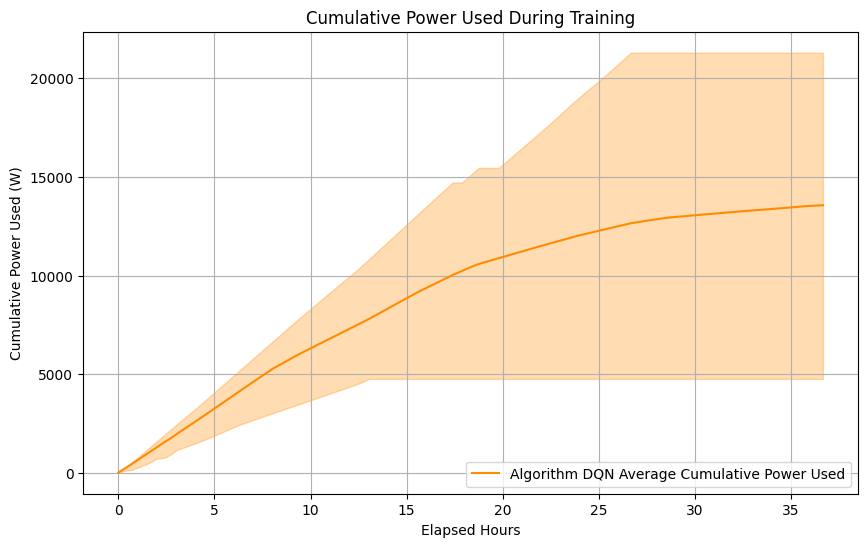

In [7]:
plt.figure(figsize=(10, 6))

t_min = df_power['time'].min()
t_max = df_power['time'].max()
time_grid = np.linspace(t_min, t_max, num=1000)  # Adjust num as needed

for algo in df_power['algorithm'].unique():
    algo_data = df_power[df_power['algorithm'] == algo]

    # Get list of experiments/runs
    experiments = algo_data['exp_num'].unique()

    # List to store interpolated cumulative_power values for each experiment
    interp_cumulative_powers = []

    for exp in experiments:
        exp_data = algo_data[algo_data['exp_num'] == exp]

        # Sort data by time
        exp_data = exp_data.sort_values('time')

        # Extract time and cumulative_power values
        exp_time = exp_data['time'].values
        exp_cum_power = exp_data['cumulative_power'].values

        # Get the maximum cumulative_power for this experiment
        max_cum_power = exp_cum_power[-1]

        # Interpolate cumulative_power over the common time grid
        # Cap the values beyond the last time point
        interp_cumulative_power = np.interp(
            time_grid,
            exp_time,
            exp_cum_power,
            left=0,  # Assuming cumulative_power is zero before the experiment starts
            right=max_cum_power  # Cap cumulative_power at max_cum_power after experiment ends
        )

        interp_cumulative_powers.append(interp_cumulative_power)

    # Convert list to numpy array for easy computation
    interp_cumulative_powers = np.array(interp_cumulative_powers)

    # Compute min, max, mean at each time point
    min_cumulative_power = np.min(interp_cumulative_powers, axis=0)
    max_cumulative_power = np.max(interp_cumulative_powers, axis=0)
    mean_cumulative_power = np.mean(interp_cumulative_powers, axis=0)

    # Convert time from seconds to hours
    time_grid_hours = time_grid / 3600.0

    # Plotting
    plt.fill_between(
        time_grid_hours, 
        min_cumulative_power, 
        max_cumulative_power,
        color=colors[algo],
        alpha=0.3
    )
    plt.plot(
        time_grid_hours, 
        mean_cumulative_power,
        color=colors[algo],
        label=f'Algorithm {algo} Average Cumulative Power Used'
    )

plt.xlabel('Elapsed Hours')
plt.ylabel('Cumulative Power Used (W)')
plt.title('Cumulative Power Used During Training')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()